In [1]:
import numpy as np
import mdtraj as md
import scattering
from scattering.utils.features import find_local_maxima
import matplotlib.pyplot as plt

In [11]:
trj = md.load(
    'water4vanHoveS/water4vanHove_DFTB/water500_3obw-d3_500-550ps_traject.xyz',
    top='water4vanHoveS/water500_3obw-d3_150-200ps.pdb'
)

/raid6/homes/raymat/software/mdtraj/mdtraj/formats/pdb/pdbfile.py:194: RuntimeWarning: divide by zero encountered in true_divide
  particle_density = traj.top.n_atoms / traj.unitcell_volumes[0]
/raid6/homes/raymat/software/mdtraj/mdtraj/formats/pdb/pdbfile.py:198: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  'cell vectors.', category=UserWarning)


500 means 500 waters, need to do 128 waters for comparison to AIMD
maybe try water128_3obw-d3_500-550ps_traject.xyz
Also need to change box sizes when changing trj

Need to use updated trj with 128 waters and 500-550 ps times
it should have box size 15.655
water128_3obw-d3_500-550ps_traject.xyz; 15.655 15.655 15.655

Ideas & to-do
* Need to compare static RDFs DFTB vs DFT (using same # waters 
* Maybe compare sampling over little chunks of 10 ps time windows, to see if there are differencs in structure over time - actually maybe not
* DFTB also wants to see comparison between d3 and no d3 (d3 is the Grimme disperson) - some questions about if the "best data" is truly best without testing it
* pick d3 vs no d3 based on if Paul is including dispersion - it seems like Paul is but need to check
* New data is at https://drive.google.com/open?id=13IbBPYzHxg91ppSthFlGWXrPJGOMpX1J
* Send instructions to Quan and Stephan about installing scattering code and doing the analysis themselves

* Data labelled: water128_3obw-d3_500-550ps_traject.xyz
  * 128 = num waters
  * d3 vs nod3 = if dispersion is on or not
  * ps numbers are start and end time

In [12]:
!ls 

data	    no_water_form   water4vanHoveS.tar.gz
dftb.ipynb  water4vanHoveS  water_form


In [13]:
trj._unitcell_angles = np.zeros((trj.n_frames, 3))
trj._unitcell_lengths = np.zeros((trj.n_frames, 3))

trj._unitcell_angles[:] = [90, 90, 90]
trj._unitcell_lengths[:] = [2.4655, 2.4655, 2.4655]

trj.time = trj.time * 0.01

In [14]:
chunk_length=200

r, t, g_r_t = scattering.compute_van_hove(trj, chunk_length=chunk_length, water=True)

doing hydrogen and hydrogen ...


100% (25 of 25) |########################| Elapsed Time: 0:00:48 Time:  0:00:48


doing hydrogen and oxygen ...


100% (25 of 25) |########################| Elapsed Time: 0:00:51 Time:  0:00:51


doing oxygen and oxygen ...


100% (25 of 25) |########################| Elapsed Time: 0:00:13 Time:  0:00:13


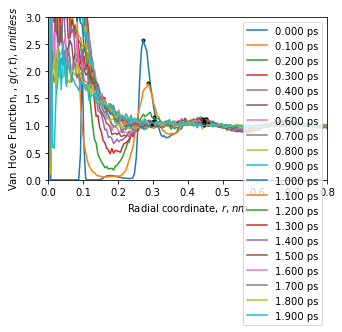

In [21]:
fig, ax = plt.subplots(figsize=(5, 3))

for j in range(chunk_length):
    if j % 10 !=0 or j > 1000:
        continue
    r_max, g_r_max = find_local_maxima(r, g_r_t[j], r_guess=0.3)
    ax.plot(r_max, g_r_max, 'k.')
    r_max, g_r_max = find_local_maxima(r, g_r_t[j], r_guess=0.45)
    ax.plot(r_max, g_r_max, 'k.')
    ax.plot(r, g_r_t[j], label='{:.3f} ps'.format(t[j]))

for ax in [ax]:
    ax.set_xlim((0, 0.8))
    ax.set_ylim((0, 3.0))
    ax.legend(loc='upper right')
    ax.set_xlabel(r'Radial coordinate, $r$, $nm$')
    ax.set_ylabel(r'Van Hove Function, , $g(r, t)$, $unitiless$')
plt.savefig('water_form/d3.pdf')

##### !pwd

In [17]:
np.savetxt('water_form/d3_r.txt', r)
np.savetxt('water_form/d3_t.txt', t)
np.savetxt('water_form/d3_vhf.txt', g_r_t)

In [8]:
pairs = trj.top.select_pairs('name O', 'name O')

In [15]:
trj.n_frames * 0.01

50.01

(0, 3)

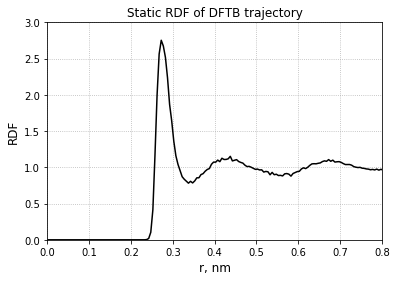

In [13]:
r, g_r = md.compute_rdf(trj[::100], pairs=pairs)

fig, ax = plt.subplots()

ax.plot(r, g_r, 'k-')

ax.set_title(r'Static RDF of DFTB trajectory')
ax.set_xlabel('r, nm')
ax.set_ylabel('RDF')
ax.set_xlim((0, 0.8))
ax.set_ylim((0, 3))

In [2]:
trj = md.load(
     'water4vanHoveS/water4vanHove_DFTB/water128_3obw-d3_500-550ps_traject.xyz',
     top='water4vanHoveS/water4vanHove_DFTB/water128.pdb'
 )

/raid6/homes/raymat/software/mdtraj/mdtraj/formats/pdb/pdbfile.py:194: RuntimeWarning: divide by zero encountered in true_divide
  particle_density = traj.top.n_atoms / traj.unitcell_volumes[0]
/raid6/homes/raymat/software/mdtraj/mdtraj/formats/pdb/pdbfile.py:198: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  'cell vectors.', category=UserWarning)


In [4]:
trj._unitcell_angles = np.zeros((trj.n_frames, 3))
trj._unitcell_lengths = np.zeros((trj.n_frames, 3))

trj._unitcell_angles[:] = [90, 90, 90]
trj._unitcell_lengths[:] = [1.5655, 1.5655, 1.5655]

trj.time = trj.time * 0.01

In [5]:
chunk_length=200

r, t, g_r_t = scattering.compute_van_hove(trj, chunk_length=chunk_length, water=True)

N/A% (0 of 25) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

doing hydrogen and hydrogen ...


100% (25 of 25) |########################| Elapsed Time: 0:00:05 Time:  0:00:05
N/A% (0 of 25) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

doing hydrogen and oxygen ...


100% (25 of 25) |########################| Elapsed Time: 0:00:05 Time:  0:00:05
N/A% (0 of 25) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

doing oxygen and oxygen ...


100% (25 of 25) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


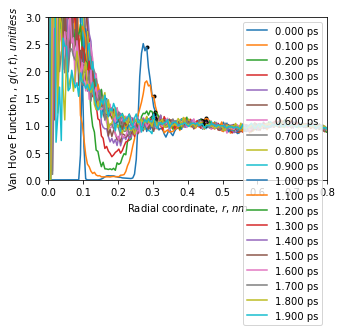

In [6]:
fig, ax = plt.subplots(figsize=(5, 3))

for j in range(chunk_length):
    if j % 10 !=0 or j > 1000:
        continue
    r_max, g_r_max = find_local_maxima(r, g_r_t[j], r_guess=0.3)
    ax.plot(r_max, g_r_max, 'k.')
    r_max, g_r_max = find_local_maxima(r, g_r_t[j], r_guess=0.45)
    ax.plot(r_max, g_r_max, 'k.')
    ax.plot(r, g_r_t[j], label='{:.3f} ps'.format(t[j]))

for ax in [ax]:
    ax.set_xlim((0, 0.8))
    ax.set_ylim((0, 3.0))
    ax.legend(loc='upper right')
    ax.set_xlabel(r'Radial coordinate, $r$, $nm$')
    ax.set_ylabel(r'Van Hove Function, , $g(r, t)$, $unitiless$')
#plt.savefig('water_form/van-hove-function.pdf')

In [19]:
# No d3
nod3 = md.load(
    'water4vanHoveS/water4vanHove_DFTB/water500_3obw-nod3_500-550ps_traject.xyz',
    top='water4vanHoveS/water500_3obw-d3_150-200ps.pdb'
)

nod3._unitcell_angles = np.zeros((nod3.n_frames, 3))
nod3._unitcell_lengths = np.zeros((nod3.n_frames, 3))

nod3._unitcell_angles[:] = [90, 90, 90]
nod3._unitcell_lengths[:] = [2.4655, 2.4655, 2.4655]

nod3.time = nod3.time * 0.01

/raid6/homes/raymat/software/mdtraj/mdtraj/formats/pdb/pdbfile.py:194: RuntimeWarning: divide by zero encountered in true_divide
  particle_density = traj.top.n_atoms / traj.unitcell_volumes[0]
/raid6/homes/raymat/software/mdtraj/mdtraj/formats/pdb/pdbfile.py:198: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  'cell vectors.', category=UserWarning)


In [20]:
chunk_length=200

no_r, no_t, no_g_r_t = scattering.compute_van_hove(nod3, chunk_length=chunk_length, water=True)

doing hydrogen and hydrogen ...


100% (25 of 25) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


doing hydrogen and oxygen ...


100% (25 of 25) |########################| Elapsed Time: 0:00:50 Time:  0:00:50


doing oxygen and oxygen ...


100% (25 of 25) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


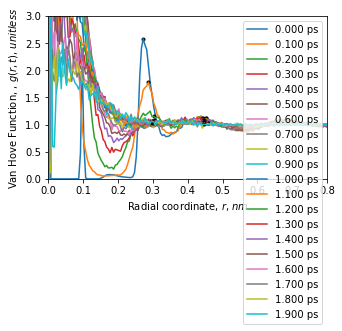

In [22]:
fig, ax = plt.subplots(figsize=(5, 3))

for j in range(chunk_length):
    if j % 10 !=0 or j > 1000:
        continue
    r_max, g_r_max = find_local_maxima(no_r, no_g_r_t[j], r_guess=0.3)
    ax.plot(r_max, g_r_max, 'k.')
    r_max, g_r_max = find_local_maxima(no_r, no_g_r_t[j], r_guess=0.45)
    ax.plot(r_max, g_r_max, 'k.')
    ax.plot(no_r, no_g_r_t[j], label='{:.3f} ps'.format(no_t[j]))

for ax in [ax]:
    ax.set_xlim((0, 0.8))
    ax.set_ylim((0, 3.0))
    ax.legend(loc='upper right')
    ax.set_xlabel(r'Radial coordinate, $r$, $nm$')
    ax.set_ylabel(r'Van Hove Function, , $g(r, t)$, $unitless$')
plt.savefig('water_form/no_d3.pdf')

#fig, ax = plt.subplots(figsize=(5, 3))

In [23]:
np.savetxt('water_form/no_d3_r.txt', no_r)
np.savetxt('water_form/no_d3_t.txt', no_t)
np.savetxt('water_form/no_d3_vhf.txt', no_g_r_t)

In [24]:
trj

<mdtraj.Trajectory with 5000 frames, 1500 atoms, 1 residues, and unitcells at 0x7f78c0244c10>

In [25]:
trj.time

array([0.000e+00, 1.000e-02, 2.000e-02, ..., 4.997e+01, 4.998e+01,
       4.999e+01])